# OH-20

## Problems with K-means

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
# Generate some data
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

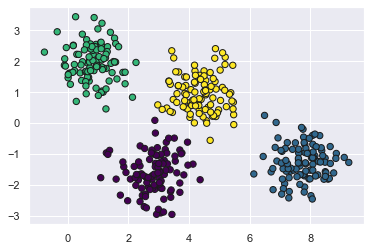

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', 
           edgecolor='k')

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2,edgecolor='k')

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1, edgecolor='k'))

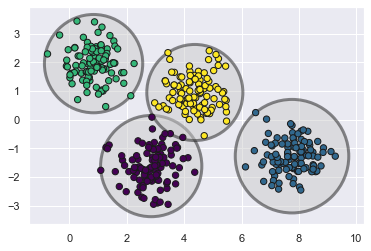

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

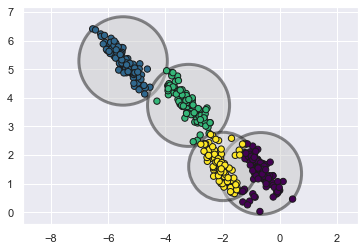

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

## Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

Under the hood, a Gaussian mixture model is very similar to k-means: it uses an expectation–maximization approach which qualitatively does the following:

- Choose starting guesses for the location and shape

- Repeat until converged:

    - E-step: for each point, find weights encoding the probability of membership in each cluster
    - M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

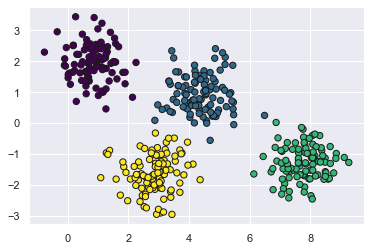

In [7]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', edgecolors="k");

In [8]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, edgecolor="k", **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, edgecolor="k")
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

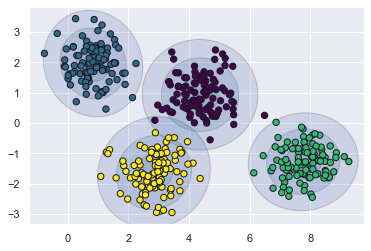

In [9]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

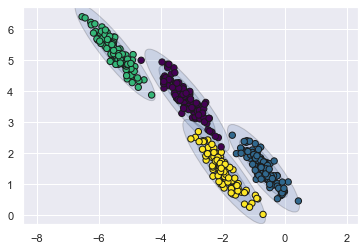

In [10]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

## Gaussian Mixture Models Implementation

In [11]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans

In [12]:
iris = datasets.load_iris()
X = iris.data
X[:20]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3]])

Let us now implement the Gaussian density function:

\begin{equation}
\large
p(\mathbf x | \mathbf\mu, \mathbf\Sigma) = \frac 1 {({2\pi})^{n/2}|\Sigma|^{1/2}}\exp\left(-\frac 1 2 (\mathbf x -\mathbf\mu)^T\mathbf\Sigma^{-1}(\mathbf x -\mathbf\mu)\right)
\end{equation}


In [14]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

You can try this function by using the code in next cell. You should obtain something like:

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

In [15]:
x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
mu = np.mean(x0, axis=0)
cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)

y = gaussian(x0, mu=mu, cov=cov)
y

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

__Step 1__

This is the initialization step of the GMM. At this point, we must initialise our parameters $\pi_k$, $\mu_k$, and $\Sigma_k$. In this case, we are going to use the results of KMeans as an initial value for $\mu_k$, set $\pi_k$ to one over the number of clusters and $\Sigma_k$ to the identity matrix. We could also use random numbers for everything, but using a sensible initialisation procedure will help the algorithm achieve better results.

In [16]:
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

**Step 2 (Expectation step)**

We should now calculate $\gamma(z_{nk})$. We can achieve this by means of the following expression:

\begin{equation}
\large
p(z_k  = 1 | x_n) =
\gamma{(z_{nk})}=\frac {\pi_k\mathcal N(\mathbf x_n| \mathbf\mu_k, \mathbf\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\mathbf x_n| \mathbf\mu_j, \mathbf\Sigma_j)}
\end{equation}

For convenience, we just calculate the denominator as a sum over all terms in the numerator, and then assign it to a variable named __totals__

In [17]:
def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
        
        for i in range(X.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']

**Step 3 (Maximization step):**

Let us now implement the maximization step. Since $\gamma(z_{nk})$ is common to the expressions for $\pi_k$, $\mu_k$ and $\Sigma_k$, we can simply define:

\begin{equation}
\large
N_k=\sum_{n=1}^N\gamma({z_{nk}})
\end{equation}

And then we can calculate the revised parameters by using:

\begin{equation}
\large
\pi_k^*=\frac {N_k} N
\end{equation}


\begin{equation}
\large
\mu_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})\mathbf x_n
\end{equation}


\begin{equation}
\large
\Sigma_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})(\mathbf x_n-\mathbf\mu_k)(\mathbf x_n-\mathbf\mu_k)^T
\end{equation}

Note: To calculate the covariance, we define an auxiliary variable __diff__ that contains $(x_n-\mu_k)^T$.

In [18]:
def maximization_step(X, clusters):
    N = float(X.shape[0])
  
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

Let us now determine the log-likelihood of the model. It is given by:

\begin{equation}
\large
\ln p(\mathbf X)=\sum_{n=1}^N\ln\sum_{k=1}^K\pi_k\mathcal N(\mathbf x_n|\mu_k,\Sigma_k)
\end{equation}

However, the second summation has already been calculated in the __expectation_step__ function and is available in the __totals__ variable. So we just make use of it.

In [19]:
def get_likelihood(X, clusters):
    sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

Finally, let's put everything together! First, we are going to initialise the parameters by using the __initialise_clusters__ function, and then perform several expectation-maximization steps. In this case, we set the number of iterations of the training procedure to a fixed __n_epochs__ number. I have done this on purpose to generate graphs of the log-likelihood later.

In [20]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        
    return clusters, likelihoods, scores, sample_likelihoods, history

Let's train our model!

In [21]:
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)

Epoch:  1 Likelihood:  -2183.364297367163
Epoch:  2 Likelihood:  -687.9930619889924
Epoch:  3 Likelihood:  -599.2443863389128
Epoch:  4 Likelihood:  -587.2166556096772
Epoch:  5 Likelihood:  -577.1883030702885
Epoch:  6 Likelihood:  -569.9844076794174
Epoch:  7 Likelihood:  -565.1009094779275
Epoch:  8 Likelihood:  -561.3665532118041
Epoch:  9 Likelihood:  -557.9066482188397
Epoch:  10 Likelihood:  -554.7082225664111
Epoch:  11 Likelihood:  -551.8847892480708
Epoch:  12 Likelihood:  -549.3689988283984
Epoch:  13 Likelihood:  -547.2652544807574
Epoch:  14 Likelihood:  -545.5594286930436
Epoch:  15 Likelihood:  -543.8235990782629
Epoch:  16 Likelihood:  -542.0117820714645
Epoch:  17 Likelihood:  -541.0209637151714
Epoch:  18 Likelihood:  -540.6999702580208
Epoch:  19 Likelihood:  -540.6012362811376
Epoch:  20 Likelihood:  -540.5705173574368
Epoch:  21 Likelihood:  -540.560887786417
Epoch:  22 Likelihood:  -540.5578476006328
Epoch:  23 Likelihood:  -540.5568826889847
Epoch:  24 Likelihood

It is always a good idea to see how the log-likelihood is making progress. So let's create a graph reflecting that value

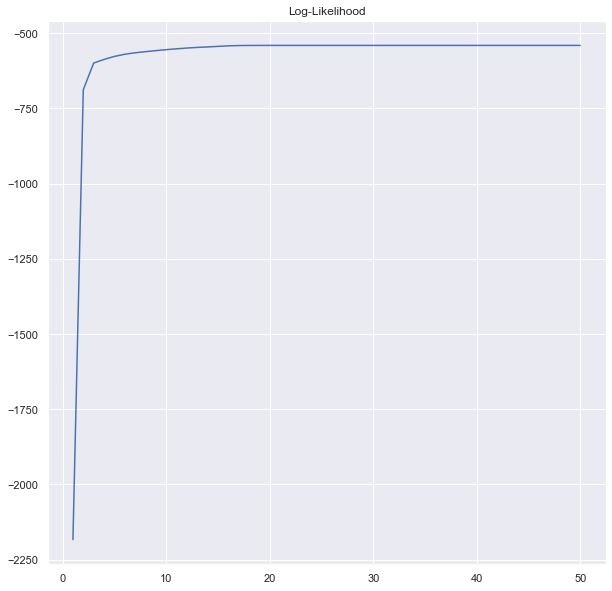

In [22]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()

Let us now create a graph to visualise our clusters as well as the parameters for the Gaussian mixture. Essentially, what we do here is to create ellipses of different scales in order to map to the coordinates of each Gaussian.

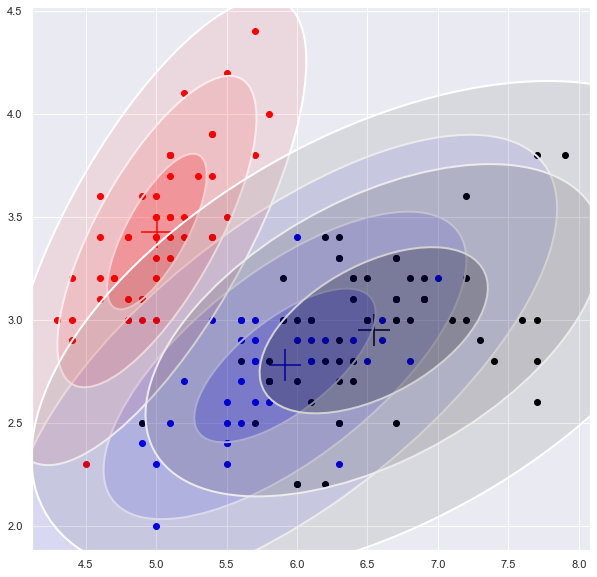

In [23]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, history, scores)

By the way, you can also watch an animation of how the cluster estimations improve. You can just open the __gmm.gif__ file generated. Let's now test if our calculations are correct. In this case, we are using sklearn's GMM implementation to check for the parameters and probabilities.

In [24]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)

print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
print('Scores by sklearn:\n', gmm_scores[0:20])
print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

Means by sklearn:
 [[5.9170732  2.77804839 4.20540364 1.29848217]
 [5.006      3.428      1.462      0.246     ]
 [6.54639415 2.94946365 5.48364578 1.98726565]]
Means by our implementation:
 [[5.91496959 2.77784365 4.20155323 1.29696685]
 [5.006      3.428      1.462      0.246     ]
 [6.54454865 2.94866115 5.47955343 1.98460495]]
Scores by sklearn:
 [ 1.57050082  0.73787138  1.14436656  0.92913238  1.411028   -0.09451903
  0.05266884  1.62442195  0.27082378  0.16706624  0.83489877  0.77168582
  0.29597841 -1.79224582 -3.41557928 -2.10529279 -1.12995447  1.47503579
 -0.84612536  0.97699215]
Scores by our implementation:
 [ 1.57057947  0.73793642  1.14444614  0.92920539  1.41110417 -0.09448868
  0.05268031  1.62449505  0.27090462  0.16702226  0.83494742  0.77171947
  0.29597776 -1.79222469 -3.41562626 -2.1052825  -1.1300608   1.47509939
 -0.84608424  0.9770596 ]
